# PEFT using LoRA (Low-rank Adapation of LLMs)

We are targeting four modules during fine-tuning: "Query", "Key", "Value", and "Dense".

# Install Packages

In [1]:
!pip install datasets
!pip install evaluate
!pip install SentencePiece
!pip install transformers[torch]
!pip install peft
!pip install Biopython
!pip install mpi4py

In [2]:
import torch
import numpy as np
import pandas as pd
import transformers
import datasets as datasets

print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.8.0+cu126
Cuda version:  12.6
Numpy version:  2.0.2
Pandas version:  2.2.2
Transformers version:  4.57.1
Datasets version:  4.0.0


# Load the training data

In [3]:
import pandas as pd
from Bio import SeqIO
import requests
from io import StringIO

# GitHub raw link
url = 'https://raw.githubusercontent.com/MirTanveer/Fine-Tune-TF/main/Data/First_layer_training.txt'

# Fetch the data from GitHub
response = requests.get(url)
response.raise_for_status()  # ensure the download worked

# Parse the FASTA data from the text
sequences = []
for record in SeqIO.parse(StringIO(response.text), "fasta"):
    # Example header format: >seq1%someinfo%LABEL=1
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extract numeric label
    sequences.append([record.name, str(record.seq), label])

# Create a DataFrame
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display
print(df.head())
print("\nTotal sequences:", len(df))


from datasets import Dataset
# Convert label column to int (already done)
df['label'] = df['label'].astype(int)

# Optional: Map label to class names if needed
label2id = {label: i for i, label in enumerate(sorted(df['label'].unique()))}
id2label = {i: label for label, i in label2id.items()}

# Convert dataframe to HuggingFace dataset
dataset = Dataset.from_pandas(df)

     name                                           sequence  label
0  Q9H161  MNAETCVSYCESPAAAMDAYYSPVSQSREGSSPFRAFPGGDKFGTT...      1
1  Q9HBZ2  MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...      1
2  E9PKN1  MADQRMDISSTISDFMSPGPTDLLSSSLGTSGVDCNRKRKGSSTDY...      1
3  P50553  MESSAKMESGGAGQQPQPQPQQPFLPPAACFFATAAAAAAAAAAAA...      1
4  P15336  MKFKLHVNSARQYKDLWNMSDDKPFLCTAPGCGQRFTNEDHLAVHK...      1

Total sequences: 832


In [4]:
dataset.shape

(832, 3)

# Define the custom head

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class CustomHeadClassifier(nn.Module):
    def __init__(self, embedding_size, hidden_size, dropout, num_classes):
        super(CustomHeadClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x, attention_mask=None):
        # x shape: (batch_size, seq_len, embedding_size)
        if attention_mask is not None:
            # masked mean pooling
            mask = attention_mask.unsqueeze(-1)  # (batch_size, seq_len, 1)
            x = (x * mask).sum(1) / mask.sum(1)
        else:
            x = x.mean(dim=1)  # mean pooling over sequence
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define LoRA config

In [6]:
from peft import LoraConfig, get_peft_model, TaskType
from transformers import AutoModelForSequenceClassification

# Load base model (e.g., ESM-2 or ProtBERT etc.)
base_model = AutoModelForSequenceClassification.from_pretrained("facebook/esm2_t6_8M_UR50D", num_labels=2)

embedding_size = base_model.config.hidden_size
base_model.classifier = CustomHeadClassifier(embedding_size, hidden_size=128, dropout=0.3, num_classes=2)

#Freeze base model
for param in base_model.parameters():
    param.requires_grad = False


# Define LoRA config
lora_config = LoraConfig(
    r=32,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "value", "key", "dense"],
    bias="all",
    task_type=TaskType.SEQ_CLS)

# Apply LoRA
model = get_peft_model(base_model, lora_config)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): EsmForSequenceClassification(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(33, 320, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-5): 6 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=320, out_features=320, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=320, out_features=32, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=32, out_features=320, bias=F

In [8]:
# for name, param in model.named_parameters():
#     param.requires_grad = is_target_block(name)

# model.print_trainable_parameters()

In [9]:
model.print_trainable_parameters()

trainable params: 1,168,707 || all params: 8,597,693 || trainable%: 13.5933


In [10]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

base_model.model.esm.encoder.layer.0.attention.self.query.base_layer.bias
base_model.model.esm.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.esm.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.esm.encoder.layer.0.attention.self.key.base_layer.bias
base_model.model.esm.encoder.layer.0.attention.self.key.lora_A.default.weight
base_model.model.esm.encoder.layer.0.attention.self.key.lora_B.default.weight
base_model.model.esm.encoder.layer.0.attention.self.value.base_layer.bias
base_model.model.esm.encoder.layer.0.attention.self.value.lora_A.default.weight
base_model.model.esm.encoder.layer.0.attention.self.value.lora_B.default.weight
base_model.model.esm.encoder.layer.0.attention.output.dense.base_layer.bias
base_model.model.esm.encoder.layer.0.attention.output.dense.lora_A.default.weight
base_model.model.esm.encoder.layer.0.attention.output.dense.lora_B.default.weight
base_model.model.esm.encoder.layer.0.attention.LayerNorm.bias
ba

In [11]:
# target_modules = [
#     "transformer.encoder.block.19.layer.0.SelfAttention.q",
#     "transformer.encoder.block.19.layer.0.SelfAttention.v",
#     "transformer.encoder.block.20.layer.0.SelfAttention.q",
#     "transformer.encoder.block.20.layer.0.SelfAttention.v",
#     "transformer.encoder.block.21.layer.0.SelfAttention.q",
#     "transformer.encoder.block.21.layer.0.SelfAttention.v",
#     "transformer.encoder.block.22.layer.0.SelfAttention.q",
#     "transformer.encoder.block.22.layer.0.SelfAttention.v",
#     "transformer.encoder.block.23.layer.0.SelfAttention.q",
#     "transformer.encoder.block.23.layer.0.SelfAttention.v"
# ]

# lora_config = LoraConfig(
#     task_type=TaskType.SEQ_CLS,
#     r=4,
#     lora_alpha=16,
#     lora_dropout=0.1,
#     target_modules=target_modules  # << This is key!
# )

# model = get_peft_model(base_model, lora_config)

# # Optional: confirm
# model.print_trainable_parameters()

In [12]:
# for name, module in base_model.named_modules():
#     print(name)

In [13]:
trainable = [name for name, param in model.named_parameters() if param.requires_grad]
frozen = [name for name, param in model.named_parameters() if not param.requires_grad]

print(f"Trainable layers: {len(trainable)}")
print(trainable[:5])  # print a few

print("\n")

print(f"Frozen layers: {len(frozen)}")
print(frozen[:5])  # print a few



from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./esm2_t6_8M_lora",
    logging_dir="./logs",
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=3e-5,
    weight_decay=0.01,
    fp16=True,
    report_to="none"
)

Trainable layers: 126
['base_model.model.esm.encoder.layer.0.attention.self.query.base_layer.bias', 'base_model.model.esm.encoder.layer.0.attention.self.query.lora_A.default.weight', 'base_model.model.esm.encoder.layer.0.attention.self.query.lora_B.default.weight', 'base_model.model.esm.encoder.layer.0.attention.self.key.base_layer.bias', 'base_model.model.esm.encoder.layer.0.attention.self.key.lora_A.default.weight']


Frozen layers: 55
['base_model.model.esm.embeddings.word_embeddings.weight', 'base_model.model.esm.encoder.layer.0.attention.self.query.base_layer.weight', 'base_model.model.esm.encoder.layer.0.attention.self.key.base_layer.weight', 'base_model.model.esm.encoder.layer.0.attention.self.value.base_layer.weight', 'base_model.model.esm.encoder.layer.0.attention.output.dense.base_layer.weight']


In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, T5Tokenizer
tokenizer =AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")

def tokenize_function(example):
    return tokenizer(example["sequence"], truncation=True, padding="max_length", max_length=1024)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

In [15]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-1658139161.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
import os
os.environ["WANDB_DISABLED"] = "true"

trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2}.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.694400,0.677933,0.778443
2,0.657800,0.626000,0.742515
3,0.591800,0.543754,0.784431
4,0.507900,0.459671,0.874251
5,0.423100,0.394397,0.898204
6,0.369700,0.351823,0.898204
7,0.327900,0.326423,0.898204
8,0.301000,0.317321,0.886228
9,0.294000,0.311992,0.886228
10,0.283200,0.308595,0.886228


TrainOutput(global_step=840, training_loss=0.44508239201136995, metrics={'train_runtime': 227.0918, 'train_samples_per_second': 29.283, 'train_steps_per_second': 3.699, 'total_flos': 350849645260800.0, 'train_loss': 0.44508239201136995, 'epoch': 10.0})

In [17]:
#ADD THIS LINE FOR DEBUGGING
#print(trainer.state.log_history)

In [18]:
# #Extract Logs
# train_loss = []
# eval_loss = []
# eval_accuracy = []
# train_steps = []
# eval_steps = []


# for log in trainer.state.log_history:
#     if 'loss' in log:
#         train_loss.append(log['loss'])
#         train_steps.append(log['step'])
#     if 'eval_loss' in log:
#         eval_loss.append(log['eval_loss'])
#         eval_accuracy.append(log['eval_accuracy'])
#         eval_steps.append(log['step'])

In [19]:
# train_loss, eval_loss, eval_accuracy

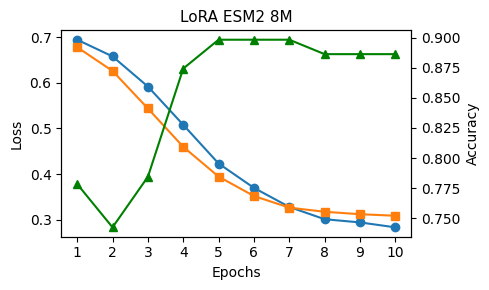

In [20]:
import matplotlib.pyplot as plt

# Example data; replace these with your real log-derived lists
#epochs = [1, 2, 3, 4, 5]
# train_loss = [0.5202, 0.309, 0.2708, 0.2419, 0.2284]
# eval_loss = [0.4150600731372833, 0.3777799904346466,0.43656858801841736,0.36971646547317505,0.3870314955711365]
# eval_accuracy = [0.8383233532934131,0.8622754491017964,0.874251497005988,0.8922155688622755,0.8922155688622755]


train_loss, eval_loss, eval_accuracy, epochs = [], [], [], []

for entry in trainer.state.log_history:
    if "loss" in entry and "epoch" in entry:
        train_loss.append(entry["loss"])
    if "eval_loss" in entry:
        eval_loss.append(entry["eval_loss"])
    if "eval_accuracy" in entry:
        eval_accuracy.append(entry["eval_accuracy"])
    if "epoch" in entry:
        epochs.append(entry["epoch"])

# Make sure x-axis aligns
x = list(range(1, len(train_loss)+1))

fig, ax1 = plt.subplots(figsize=(5, 3))

# Plot loss curves on the left y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(x, train_loss,   marker='o')
ax1.plot(x, eval_loss,   marker='s')
ax1.set_xticks(x)
ax1.tick_params(axis='y')

# Instantiate a second axes sharing the same x-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy')
ax2.plot(x, eval_accuracy, color='green', marker='^')
ax2.tick_params(axis='y')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
#ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')
#ax2.set_ylim(0.8, 0.95)
plt.title('LoRA ESM2 8M', fontsize=11)
#plt.grid(True)
plt.tight_layout()
#plt.savefig('../Figures/With_LoRA/New/LoRA_ESM2_8M.png', dpi=400)  # Save the figure
plt.show()

In [21]:
# Directory to save
# Save model, tokenzier, and Custom Head Classifier separately
# The standard save_pretrained method from Transformers won’t automatically save the custom head class code.
# We need to save both the model weights and the custom head properly.

save_dir = "Saved_Models/LoRA_ESM2_8M_model_with_custom_head"

# Save Hugging Face model weights (excluding custom head)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

# Save custom head weights separately
torch.save(model.classifier.state_dict(), f"{save_dir}/custom_head.pt")

## Inference

In [22]:
import pandas as pd
from Bio import SeqIO
import requests
from io import StringIO

# GitHub raw link
url = 'https://raw.githubusercontent.com/MirTanveer/Fine-Tune-TF/main/Data/First_Layer_Independent.txt'

# Fetch the data from GitHub
response = requests.get(url)
response.raise_for_status()  # ensure the download worked

# Parse the FASTA data from the text
sequences = []
for record in SeqIO.parse(StringIO(response.text), "fasta"):
    # Example header format: >seq1%someinfo%LABEL=1
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extract numeric label
    sequences.append([record.name, str(record.seq), label])

# Create a DataFrame
df_test= pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display
print(df_test.head())
print("\nTotal sequences:", len(df_test))


     name                                           sequence  label
0  A6NJG6  MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSG...      1
1  Q96QS3  MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...      1
2  Q8N100  MKSCKPSGPPAGARVAPPCAGGTECAGTCAGAGRLESAARRRLAAN...      1
3  Q9NY43  MTMEGASGSSFGIDTILSSASSGSPGMMNGDFRPLGEARTADFRSQ...      1
4  Q96T88  MWIQVRTMDGRQTHTVDSLSRLTKVEELRRKIQELFHVEPGLQRLF...      1

Total sequences: 212


In [23]:
from datasets import Dataset

df_test["label"] = df_test["label"].astype(int)
test_dataset = Dataset.from_pandas(df_test)

In [24]:
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

In [25]:
from transformers import Trainer

trainer_test = Trainer(model=model, tokenizer=tokenizer)

predictions = trainer_test.predict(test_dataset)

/tmp/ipython-input-2552209075.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_test = Trainer(model=model, tokenizer=tokenizer)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [26]:
import numpy as np
import torch.nn.functional as F
logits = predictions.predictions
labels = predictions.label_ids
preds = np.argmax(logits, axis=-1)
probs = F.softmax(torch.tensor(logits), dim=-1).numpy()  # shape: [N, num_classes]


In [27]:
from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(labels, preds)
print(f"Test Accuracy: {acc:.4f}")

# Optional: detailed report
print(classification_report(labels, preds))

Test Accuracy: 0.9198
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       106
           1       0.93      0.91      0.92       106

    accuracy                           0.92       212
   macro avg       0.92      0.92      0.92       212
weighted avg       0.92      0.92      0.92       212



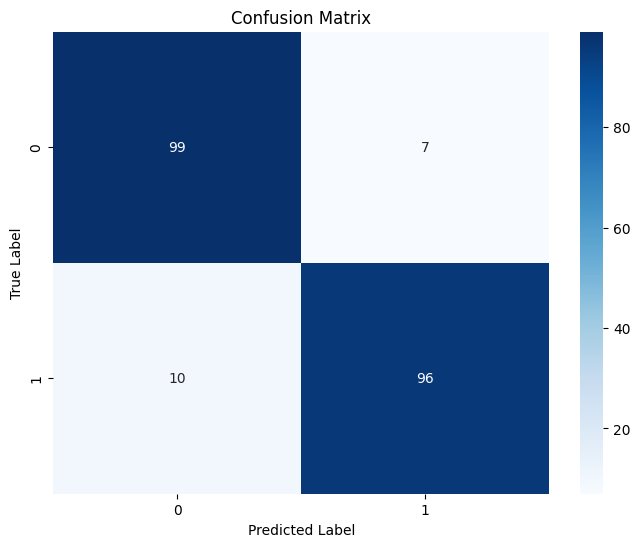

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [29]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
auc = roc_auc_score(labels, probs[:, 1])
print(f"AUC Score (Binary): {auc:.4f}")

AUC Score (Binary): 0.9413


In [30]:
TN, FP, FN, TP = cm.ravel()

In [31]:
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
specificity= TN / (TN + FP) if (TN + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Recall = Sensitivity
# Matthews correlation coefficient
import numpy as np
numerator = (TP * TN) - (FP * FN)
denominator = np.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN))
mcc = numerator / denominator if denominator > 0 else 0
F1_score= (2*precision*recall)/(precision+recall)

In [32]:
print("Precision value is: ", precision)
print("Specificity value is: ", specificity)
print("Recall value is: ", recall)
print("Mcc score is: ", mcc)
print("F1 Score is: ", F1_score)

Precision value is:  0.9320388349514563
Specificity value is:  0.9339622641509434
Recall value is:  0.9056603773584906
Mcc score is:  0.8399591111791317
F1 Score is:  0.9186602870813397
